In [1]:
import yfinance as yf
import pandas as pd
import os

In [2]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [3]:
# sp500.index = pd.to_datetime(sp500.index)

In [4]:
# Ensure it's parsed as datetime first
sp500.index = pd.to_datetime(sp500.index, utc=True)  # Forcefully makes it tz-aware

# Then remove the timezone
sp500.index = sp500.index.tz_convert(None)

# Now safely filter from 1990 onwards
sp500 = sp500.loc["1990-01-01":].copy()

In [5]:
sp500.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1990-01-02 05:00:00,353.399994,359.690002,351.980011,359.690002,162070000,0.0,0.0
1990-01-03 05:00:00,359.690002,360.589996,357.890015,358.760010,192330000,0.0,0.0
1990-01-04 05:00:00,358.760010,358.760010,352.890015,355.670013,177000000,0.0,0.0
1990-01-05 05:00:00,355.670013,355.670013,351.350006,352.200012,158530000,0.0,0.0
1990-01-08 05:00:00,352.200012,354.239990,350.540009,353.790009,140110000,0.0,0.0


This is not a dataset of all S&P 500 company stock prices.
It’s just the index value for the S&P 500 — a single composite time series.
the dataset is only for one asset — the ^GSPC index. Each row shows one day of S&P 500 aggregate movement — like a market pulse.


In [7]:
del sp500["Dividends"]
del sp500["Stock Splits"]

## EDA

trading volume is not steady over time — it reflects technology, investor behavior, and global events.
Major spikes (like in 2008 & 2020) align with market crashes, while general growth reflects the democratization of investing.

This heatmap confirms that most price features are redundant (correlated 1.0), but volume and volatility (rolling std) add independent signals that could be useful in a trading or prediction model.

In [11]:
# Apply standard single exponential smoothing (SES) to the Close price
alpha = 0.3  # smoothing factor (between 0 and 1)

sp500["SES_Close"] = sp500["Close"].ewm(alpha=alpha, adjust=False).mean()

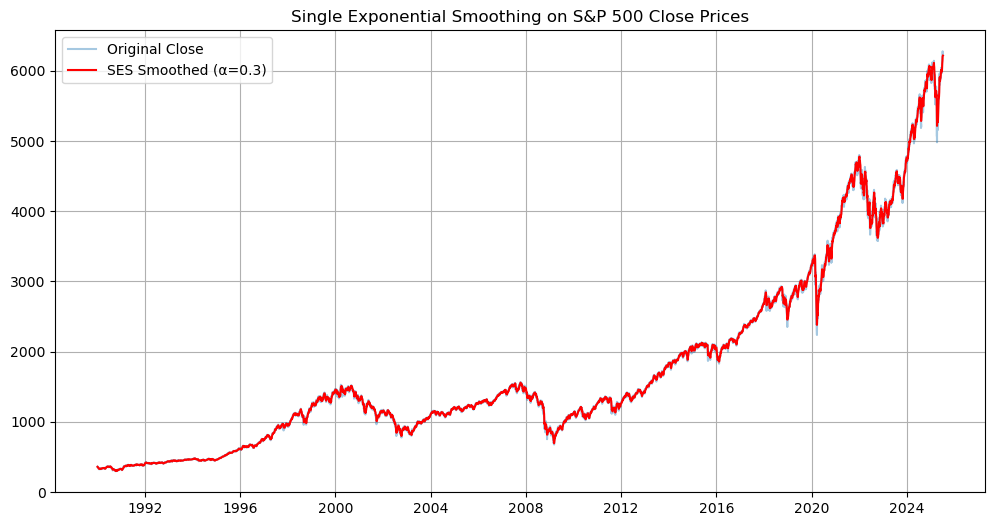

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(sp500["Close"], label="Original Close", alpha=0.4)
plt.plot(sp500["SES_Close"], label=f"SES Smoothed (α={alpha})", color='red')
plt.title("Single Exponential Smoothing on S&P 500 Close Prices")
plt.legend()
plt.grid(True)
plt.show()

## Random Forest 

In [14]:
sp500.drop('Close', axis=1,inplace=True)

In [15]:
sp500.rename(columns={'SES_Close':'Close'},inplace=True)

In [16]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [17]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [18]:
sp500

,Open,High,Low,Volume,Close,Tomorrow,Target
Date,,,,,,,
1990-01-02 05:00:00,353.399994,359.690002,351.980011,162070000,359.690002,359.411005,0
1990-01-03 05:00:00,359.690002,360.589996,357.890015,192330000,359.411005,358.288707,0
1990-01-04 05:00:00,358.760010,358.760010,352.890015,177000000,358.288707,356.462099,0
1990-01-05 05:00:00,355.670013,355.670013,351.350006,158530000,356.462099,355.660472,0
1990-01-08 05:00:00,352.200012,354.239990,350.540009,140110000,355.660472,353.848329,0
...,...,...,...,...,...,...,...
2025-07-01 04:00:00,6187.250000,6210.779785,6177.970215,6275310000,6153.578444,6175.730888,1
2025-07-02 04:00:00,6193.879883,6227.600098,6188.290039,5645710000,6175.730888,6206.816651,1
2025-07-03 04:00:00,6246.459961,6284.649902,6246.459961,3378110000,6206.816651,6213.765650,1


In [19]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [20]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)  #did it actually go up. 

0.575

$$\text{Precision} = \frac{TP}{TP + FP}$$

We can't trust this model. Let's do back testing, and also try to incorporate more features 

<Axes: xlabel='Date'>

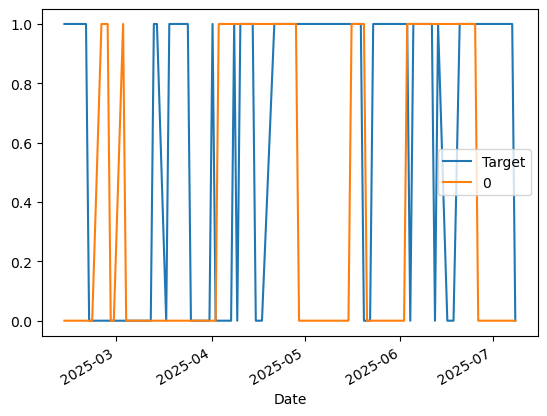

In [23]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

Target is soscillating a lot, but the prediction is almost stable predicting 1 most of the times. Model needs to be improved.

In [25]:
#back testing 

In [26]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [27]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [28]:
def backtest(data, model, predictors, start=2500, step=250): #10 years of data to train,and predict 11th year, then 11 year data to train and predict 12th year and go on
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
        print(accuracy_score(predictions["Target"], predictions["Predictions"]))
    
    return pd.concat(all_predictions)

## Backtest Model 1

In [30]:
predictions = backtest(sp500, model, predictors)

0.504
0.568
0.52
0.48
0.628
0.524
0.484
0.616
0.576
0.424
0.616
0.544
0.612
0.476
0.68
0.424
0.512
0.352
0.664
0.596
0.464
0.508
0.48
0.592
0.588
0.5360824742268041


<Axes: xlabel='Date'>

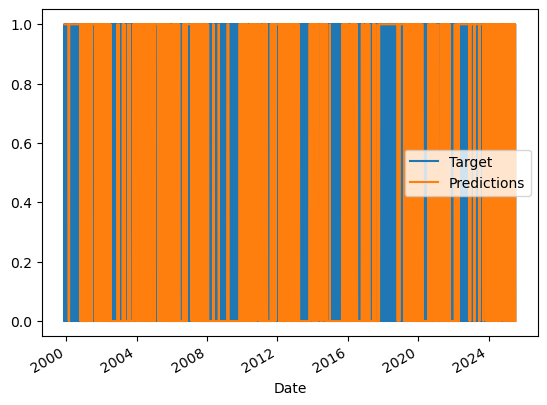

In [31]:
predictions.plot()

In [32]:
import matplotlib.pyplot as plt

def plot_prediction_bands(predictions, title="Target vs Predictions: S&P 500 Up Days"):
    """
    Plots Target vs Prediction with heatmap-style shaded bands indicating:
    - True Positives (Correct UP)
    - False Positives (Wrong Buy)
    - False Negatives (Missed UP)

    Parameters:
        predictions (pd.DataFrame): Must contain 'Target' and 'Predictions' columns
        title (str): Optional title for the plot
    """
    plt.figure(figsize=(16, 5))

    # Plot target and prediction lines
    plt.plot(predictions.index, predictions["Target"], label="Actual (Target)", color="#0077b6", linewidth=1.8)
    plt.plot(predictions.index, predictions["Predictions"], label="Prediction", color="#f77f00", linewidth=1.5, alpha=0.8)

    # True Positives
    plt.fill_between(predictions.index, 0, 1,
                     where=(predictions["Target"] == 1) & (predictions["Predictions"] == 1),
                     color='#2a9d8f', alpha=0.3, label='✅ Correct UP (True Positive)')

    # False Positives
    plt.fill_between(predictions.index, 0, 1,
                     where=(predictions["Target"] == 0) & (predictions["Predictions"] == 1),
                     color='#e63946', alpha=0.25, label='❌ False Positive (Wrong Buy)')

    # False Negatives
    plt.fill_between(predictions.index, 0, 1,
                     where=(predictions["Target"] == 1) & (predictions["Predictions"] == 0),
                     color='#9b5de5', alpha=0.25, label='❌ Missed UP (False Negative)')

    # Final formatting
    plt.title(title, fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Up = 1, Down = 0")
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()

/var/folders/1h/1px02wgx233fjvxxzjdt1d900000gn/T/ipykernel_64640/3630411649.py:41: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/var/folders/1h/1px02wgx233fjvxxzjdt1d900000gn/T/ipykernel_64640/3630411649.py:41: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


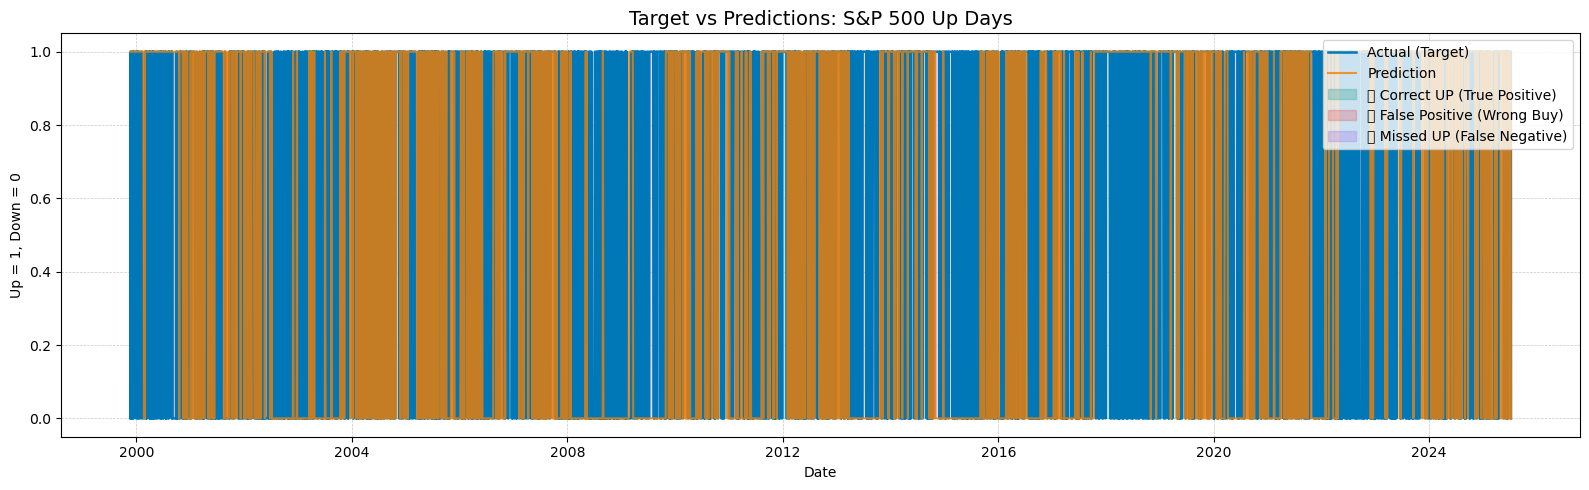

In [33]:
plot_prediction_bands(predictions)

In [34]:
predictions["Predictions"].value_counts()

Predictions
1    3393
0    3051
Name: count, dtype: int64

In [35]:
precision_score(predictions["Target"], predictions["Predictions"]), accuracy_score(predictions["Target"], predictions["Predictions"])

(0.6268788682581786, 0.537243947858473)

In [36]:
predictions["Target"].value_counts() / predictions.shape[0]  #Percentage of times the market actually went up

Target
1    0.596369
0    0.403631
Name: count, dtype: float64

## backtest model 2

In [38]:
#adding additional predictors

In [39]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"] #ratio of close values. Today's close value with rolling average 
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"] #how many days in the horizon, price went up.
    
    new_predictors+= [ratio_column, trend_column]

In [40]:
new_predictors

['Close_Ratio_2',
 'Trend_2',
 'Close_Ratio_5',
 'Trend_5',
 'Close_Ratio_60',
 'Trend_60',
 'Close_Ratio_250',
 'Trend_250',
 'Close_Ratio_1000',
 'Trend_1000']

In [41]:
for col in new_predictors:
    sp500[col] = sp500[col].shift(1)

In [42]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [43]:
sp500.head()

,Open,High,Low,Volume,Close,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-15 05:00:00,463.059998,463.690002,461.839996,331770000,463.632330,463.544630,0,0.999382,1.0,0.998994,2.0,1.003684,36.0,1.031681,147.0,1.180219,541.0
1993-12-16 05:00:00,461.859985,463.980011,461.859985,284620000,463.544630,464.395242,1,0.999172,0.0,0.998067,1.0,1.001776,36.0,1.029721,146.0,1.177955,541.0
1993-12-17 05:00:00,463.339996,466.380005,463.339996,363750000,464.395242,464.831672,1,0.999905,0.0,0.998495,1.0,1.001336,36.0,1.029287,145.0,1.177417,541.0
1993-12-20 05:00:00,466.380005,466.899994,465.529999,255900000,464.831672,464.972166,1,1.000917,1.0,1.000443,2.0,1.002905,36.0,1.030936,145.0,1.179254,542.0
1993-12-21 05:00:00,465.839996,465.920013,464.029999,273370000,464.972166,465.676519,1,1.000470,2.0,1.001445,2.0,1.003570,36.0,1.031663,145.0,1.180035,543.0


In [44]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [88]:
predictions = backtest(sp500, model, new_predictors)

0.632
0.636
0.612
0.644
0.604
0.62
0.64
0.648
0.652
0.712
0.616
0.636
0.668
0.628
0.624
0.704
0.676
0.428
0.652
0.608
0.66
0.689119170984456


In [90]:
predictions["Predictions"].value_counts()

Predictions
1.0    2774
0.0    2669
Name: count, dtype: int64

In [92]:
precision_score(predictions["Target"], predictions["Predictions"]), accuracy_score(predictions["Target"], predictions["Predictions"])

(0.7465753424657534, 0.6353114091493661)

In [94]:
recall_score(predictions["Target"], predictions["Predictions"]), f1_score(predictions["Target"], predictions["Predictions"])

(0.6176558305994632, 0.6760241553778358)

In [96]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.616021
0    0.383979
Name: count, dtype: float64

In [100]:
# This Model performs better , 75% Precision and 63.5% Accuracy 

Let's try to do hyper parameter tuning as well and see if the model improves or not.

## Hyper Parameter Tuning

In [109]:
param_grid = {
    'n_estimators': [50,100, 200],
    'min_samples_split': [25, 50, 100],
    'max_depth': [5, 10]
}

In [119]:
results = []
# Loop over combinations
for n in param_grid['n_estimators']:
    for split in param_grid['min_samples_split']:
        for depth in param_grid['max_depth']:
            print(f"\n🔍 Testing: n_estimators={n}, min_samples_split={split}, max_depth={depth}")

            model = RandomForestClassifier(
                n_estimators=n,
                min_samples_split=split,
                max_depth=depth,
                random_state=1
            )

            # Run your backtest
            predictions = backtest(sp500, model, new_predictors)
            precision = precision_score(predictions["Target"], predictions["Predictions"], zero_division=0)
            accuracy = accuracy_score(predictions["Target"], predictions["Predictions"])

            # Save results
            results.append({
                'n_estimators': n,
                'min_samples_split': split,
                'max_depth': depth,
                'precision': precision,
                'accuracy': accuracy
            })

# Show sorted results
import pandas as pd
results_df = pd.DataFrame(results).sort_values(by='accuracy', ascending=False)
print("\n📊 Top Performing Configs:")
display(results_df.head(10))


🔍 Testing: n_estimators=50, min_samples_split=25, max_depth=5
0.676
0.644
0.612
0.648
0.612
0.636
0.672
0.636
0.644
0.716
0.628
0.636
0.664
0.648
0.648
0.708
0.708
0.664
0.64
0.62
0.7
0.6528497409326425

🔍 Testing: n_estimators=50, min_samples_split=25, max_depth=10
0.656
0.636
0.608
0.64
0.608
0.58
0.664
0.632
0.656
0.704
0.616
0.632
0.668
0.624
0.668
0.724
0.656
0.48
0.64
0.616
0.692
0.6839378238341969

🔍 Testing: n_estimators=50, min_samples_split=50, max_depth=5
0.68
0.64
0.604
0.644
0.608
0.636
0.684
0.64
0.656
0.712
0.632
0.64
0.66
0.644
0.652
0.708
0.72
0.656
0.648
0.632
0.704
0.6528497409326425

🔍 Testing: n_estimators=50, min_samples_split=50, max_depth=10
0.64
0.64
0.6
0.644
0.584
0.588
0.656
0.632
0.648
0.712
0.624
0.644
0.676
0.624
0.632
0.696
0.656
0.436
0.656
0.62
0.684
0.6735751295336787

🔍 Testing: n_estimators=50, min_samples_split=100, max_depth=5
0.688
0.632
0.608
0.648
0.612
0.636
0.672
0.644
0.652
0.716
0.624
0.644
0.66
0.64
0.648
0.704
0.696
0.656
0.652
0.628
0.6

,n_estimators,min_samples_split,max_depth,precision,accuracy
10,100,100,5,0.747505,0.657358
12,200,25,5,0.746600,0.657174
2,50,50,5,0.746516,0.656991
16,200,100,5,0.745617,0.656807
6,100,25,5,0.747583,0.656807
14,200,50,5,0.744955,0.656072
4,50,100,5,0.745105,0.655337
8,100,50,5,0.745430,0.655337
0,50,25,5,0.745672,0.655153
11,100,100,10,0.748179,0.646886


model performs better at combination n_estimators=100, min_samples_split=100, max_depth=5

This is the END. I tried differnet things to improve the performance of the model but it didnt work out.

## back test model 2.5

In [ ]:
sp500['MA_10'] = sp500['Close'].rolling(10).mean()
sp500['MA_50'] = sp500['Close'].rolling(50).mean()

# Crossover: 1 if short MA above long MA → bullish trend
sp500['MA_Crossover'] = (sp500['MA_10'] > sp500['MA_50']).astype(int)

In [ ]:
predictors_1 = ['MA_10', 'MA_50','MA_Crossover' ]

In [ ]:
for col in predictors_1:
    sp500[col] = sp500[col].shift(1)

In [ ]:
new_predictors+=['MA_10', 'MA_50','MA_Crossover' ]

In [ ]:
predictions = backtest(sp500, model, new_predictors)

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"]), accuracy_score(predictions["Target"], predictions["Predictions"])

In [ ]:
#This didnt Improve the Model

## backtest model 3

In [ ]:
## Introducing Other New Predictors

In [ ]:
import numpy as np
log_hl = np.log(sp500['High'] / sp500['Low'])
log_co = np.log(sp500['Close'] / sp500['Open'])
sp500['Garman_Klass'] = 0.5 * log_hl ** 2 - (2 * np.log(2) - 1) * log_co ** 2

**finding the important features for the model**

In [ ]:
delta = sp500['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
RS = gain / loss
sp500['RSI'] = 100 - (100 / (1 + RS))

In [ ]:
ma = sp500['Close'].rolling(20).mean()
std = sp500['Close'].rolling(20).std()
sp500['Boll_Upper'] = ma + 2 * std
sp500['Boll_Lower'] = ma - 2 * std
sp500['Boll_Width'] = sp500['Boll_Upper'] - sp500['Boll_Lower']

In [ ]:
sp500.drop(['Boll_Upper', 'Boll_Lower'],inplace=True, axis=1)

In [ ]:
high_low = sp500['High'] - sp500['Low']
high_close = np.abs(sp500['High'] - sp500['Close'].shift())
low_close = np.abs(sp500['Low'] - sp500['Close'].shift())
tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
sp500['ATR'] = tr.rolling(14).mean()

In [ ]:
ema12 = sp500['Close'].ewm(span=12).mean()
ema26 = sp500['Close'].ewm(span=26).mean()
sp500['MACD'] = ema12 - ema26
sp500['MACD_Signal'] = sp500['MACD'].ewm(span=9).mean()
sp500['MACD_Diff'] = sp500['MACD'] - sp500['MACD_Signal']

In [ ]:
sp500.drop(['MACD_Signal', 'MACD'],axis=1, inplace=True)

In [ ]:
sp500['Dollar_Volume'] = sp500['Close'] * sp500['Volume']

In [ ]:
for days in [5, 10, 20, 40]:
    sp500[f'Return_{days}d'] = sp500['Close'].pct_change(periods=days)

In [ ]:
sp500.dropna(inplace=True)

In [ ]:
# 2. Stochastic Oscillator (%K)
low_14 = sp500["Close"].rolling(window=14).min()
high_14 = sp500["Close"].rolling(window=14).max()
sp500["Stochastic_%K"] = 100 * (sp500["Close"] - low_14) / (high_14 - low_14)

# 3. Williams %R
sp500["Williams_%R"] = -100 * (high_14 - sp500["Close"]) / (high_14 - low_14)

# 5. Price Rate of Change (ROC)
sp500["ROC"] = sp500["Close"].pct_change(periods=12) * 100

# 6. On Balance Volume (OBV)
obv = [0]
for i in range(1, len(sp500)):
    if sp500["Close"].iloc[i] > sp500["Close"].iloc[i-1]:
        obv.append(obv[-1] + sp500["Volume"].iloc[i])
    elif sp500["Close"].iloc[i] < sp500["Close"].iloc[i-1]:
        obv.append(obv[-1] - sp500["Volume"].iloc[i])
    else:
        obv.append(obv[-1])
sp500["OBV"] = obv

In [ ]:
new_predictors = sp500[sp500.columns[7:]].columns.tolist()

In [ ]:
new_predictors

In [ ]:
new_items = ['Garman_Klass',
 'RSI',
 'Boll_Width',
 'ATR',
 'MACD_Diff',
 'Dollar_Volume',
 'Return_5d',
 'Return_10d',
 'Return_20d',
 'Return_40d','Stochastic_%K',
 'Williams_%R',
 'ROC',
 'OBV']

In [ ]:
# Shift each predictor column by 1 to prevent leakage 
for col in new_items:   #all the predictors were calculated by today's close value which can only be used tomorrow.
    sp500[col] = sp500[col].shift(1)

In [ ]:
# Drop rows with NaNs caused by shifting
sp500.dropna(inplace=True)

In [ ]:
predictions = backtest(sp500, model, new_predictors)

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"]), accuracy_score(predictions["Target"], predictions["Predictions"])

In [ ]:
#Model Hasn't improved in terms of accuracy

## backtest model 4

In [ ]:
## Adding Regime Aware Features

In [ ]:
sp500['Volatility_20d'] = sp500['Close'].rolling(20).std()

# Label regime: Low = 0, Medium = 1, High = 2 based on percentiles
sp500['Vol_Regime'] = pd.qcut(sp500['Volatility_20d'], q=3, labels=[0, 1, 2])
	# •	Uses 20-day rolling std dev (1 month)
	# •	Vol_Regime = 0 → Low volatility
	# •	Vol_Regime = 2 → High volatility

In [ ]:
# sp500['MA_10'] = sp500['Close'].rolling(10).mean()
# sp500['MA_50'] = sp500['Close'].rolling(50).mean()

# # Crossover: 1 if short MA above long MA → bullish trend
# sp500['MA_Crossover'] = (sp500['MA_10'] > sp500['MA_50']).astype(int)

# 	# •	MA10 above MA50 = short-term uptrend
# 	# •	This binary crossover flag is a powerful trend indicator

In [ ]:
sp500['MA_200'] = sp500['Close'].rolling(200).mean()

# Bull flag = 1 if price is above 200-day MA
sp500['Bull_Flag'] = (sp500['Close'] > sp500['MA_200']).astype(int)

In [ ]:
# Shift to avoid leakage
for col in ['Vol_Regime', 'Bull_Flag']:
    sp500[col] = sp500[col].shift(1)

sp500.dropna(inplace=True)

In [ ]:
new_predictors += ['Vol_Regime', 'Bull_Flag']

In [ ]:
predictions = backtest(sp500, model, new_predictors)

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"]), accuracy_score(predictions["Target"], predictions["Predictions"])

In [ ]:
#Model didn't Improve

In [ ]:
def check_target_imbalance(data, start=2500, step=250):
    for i in range(start, data.shape[0], step):
        window = data.iloc[i:i+step].copy()
        value_counts = window["Target"].value_counts(normalize=True)  # Proportions
        count_values = window["Target"].value_counts()               # Raw counts

        print(f"\n🧾 Backtest window {i} to {i+step}:")
        print("Raw counts:")
        print(count_values.to_string())
        print("Proportion:")
        print(value_counts.round(3).to_string())

        if 1 not in count_values:
            print("⚠️ Warning: No '1' (up) signals in this window.")

# Run the check
check_target_imbalance(sp500)

**There is no class imbalance, so we can ignore class_weight='balanced' argument**

## Parameter Tuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import numpy as np

# Parameter grid to test


# Store results
results = []

# Loop over combinations
for n in param_grid['n_estimators']:
    for split in param_grid['min_samples_split']:
        for depth in param_grid['max_depth']:
            print(f"\n🔍 Testing: n_estimators={n}, min_samples_split={split}, max_depth={depth}")

            model = RandomForestClassifier(
                n_estimators=n,
                min_samples_split=split,
                max_depth=depth,
                random_state=1
            )

            # Run your backtest
            predictions = backtest(sp500, model, top_features)
            precision = precision_score(predictions["Target"], predictions["Predictions"], zero_division=0)

            # Save results
            results.append({
                'n_estimators': n,
                'min_samples_split': split,
                'max_depth': depth,
                'precision': precision
            })

# Show sorted results
import pandas as pd
results_df = pd.DataFrame(results).sort_values(by='precision', ascending=False)
print("\n📊 Top Performing Configs:")
display(results_df.head(10))

**We got good results for backtest model 2. Let's try to tune that**

In [ ]:
features_model2 = ['Close_Ratio_2',
 'Trend_2',
 'Close_Ratio_5',
 'Trend_5',
 'Close_Ratio_60',
 'Trend_60',
 'Close_Ratio_250',
 'Trend_250',
 'Close_Ratio_1000',
 'Trend_1000']

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'min_samples_split': [25, 50, 100],
    'max_depth': [None, 5, 10]
}

In [ ]:
# Loop over combinations
for n in param_grid['n_estimators']:
    for split in param_grid['min_samples_split']:
        for depth in param_grid['max_depth']:
            print(f"\n🔍 Testing: n_estimators={n}, min_samples_split={split}, max_depth={depth}")

            model = RandomForestClassifier(
                n_estimators=n,
                min_samples_split=split,
                max_depth=depth,
                random_state=1
            )

            # Run your backtest
            predictions = backtest(sp500, model, features_model2)
            precision = precision_score(predictions["Target"], predictions["Predictions"], zero_division=0)

            # Save results
            results.append({
                'n_estimators': n,
                'min_samples_split': split,
                'max_depth': depth,
                'precision': precision
            })

# Show sorted results
import pandas as pd
results_df = pd.DataFrame(results).sort_values(by='precision', ascending=False)
print("\n📊 Top Performing Configs:")
display(results_df.head(10))

**We are getting precision of 0.64 and all these higher values but, these combinations are not giving consistent performance over the years**

I have tested these before concluding. 

So, Among these the model which performed better, i will go ahead with that, mentioning that below.

In [ ]:
model = RandomForestClassifier(n_estimators=200,
                min_samples_split=50,
                random_state=1
            )

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]#predict_proba() returns probabilities for each class. [:, 1] selects the probability that the model assigns to the positive class (Target=1) — i.e., the market will go up tomorrow.
    preds[preds >=0.6] = 1
    preds[preds <0.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    # print("Total predicted 1s in this window:", combined["Predictions"].sum())
    return combined

In [ ]:
def backtest(data, model, predictors, start=2500, step=250): #10 years of data to train,and predict 11th year, then 11 year data to train and predict 12th year and go on
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
        print(precision_score(predictions["Target"], predictions["Predictions"]))
    
    return pd.concat(all_predictions)



In [ ]:
predictions = backtest(sp500, model, features_model2)

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"]) 

**Now, let's try to change the target variable by a bit and see how the model performs**

## predicts whether price 5 days later is higher → removes daily noise

When we do this, the oscillation reduces. Daily returns are full of short-term volatility. But over 5 days, a real trend has more time to develop, making it more “learnable” by a machine learning model.
You’re now predicting a mini-trend, not a single-day wiggle.

In [ ]:
sp500["Target2"] = (sp500["Close"].shift(-30) > sp500["Close"]).astype(int)

In [ ]:
sp500.dropna(inplace=True)

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target2"])
    preds = model.predict_proba(test[predictors])[:,1]#predict_proba() returns probabilities for each class. [:, 1] selects the probability that the model assigns to the positive class (Target=1) — i.e., the market will go up tomorrow.
    preds[preds >=0.59] = 1
    preds[preds <0.59] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target2"], preds], axis=1)
    # print("Total predicted 1s in this window:", combined["Predictions"].sum())
    return combined

In [ ]:
def backtest(data, model, predictors, start=2500, step=250): #10 years of data to train,and predict 11th year, then 11 year data to train and predict 12th year and go on
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
        print(precision_score(predictions["Target2"], predictions["Predictions"]))
    
    return pd.concat(all_predictions)



In [ ]:
predictions = backtest(sp500, model, features_model2)

In [ ]:
precision_score(predictions["Target2"], predictions["Predictions"]) 

In [ ]:
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features_model2,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df = feature_importance_df.reset_index()
feature_importance_df

### Logistic Regression

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
data

In [ ]:
# Drop rows with missing values (if not already done)
data = sp500.dropna()

# Define features and target
X = data.drop(columns=["Target","Tomorrow"],axis=1)
y = data["Target"]


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Use 80% for training, 20% for testing (no shuffling for time series)
split_point = int(0.8 * len(data))
X_train, X_test = X_scaled[:split_point], X_scaled[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

# Evaluate
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Recall:    {recall:.4f}")

In [ ]:
feature_importance = pd.Series(model.coef_[0], index=data.columns.drop(['Target','Tomorrow']))
print(feature_importance.sort_values(ascending=False))

### Logistic Regression Model 2, After selecting top features

In [ ]:
# Get absolute values and sort
top_features = feature_importance.abs().sort_values(ascending=False).head(10).index
print(top_features)
# Filter the original data
X_selected = data[top_features]
y = data["Target"]


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

In [ ]:
# Use 80% for training, 20% for testing (no shuffling for time series)
split_point = int(0.8 * len(data))
X_train, X_test = X_scaled[:split_point], X_scaled[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

# Evaluate
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Recall:    {recall:.4f}")

## XGBoost

In [ ]:
! pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler


In [ ]:
# Drop missing values (if any)
data = data.dropna()

# Define features and target
X = data.drop(columns=["Target","Tomorrow"])
y = data["Target"]

# Scale features (optional but often helps)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
# Use 80% of data for training (chronologically)
split_point = int(0.8 * len(data))
X_train, X_test = X_scaled[:split_point], X_scaled[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

In [ ]:
# Initialize model with basic settings
model = xgb.XGBClassifier(
    n_estimators=100,        # number of trees
    max_depth=4,             # tree depth
    learning_rate=0.1,       # step size shrinkage
    subsample=0.8,           # % of rows per tree
    colsample_bytree=0.8,    # % of features per tree
    use_label_encoder=False,
    eval_metric='logloss'    # avoid warning for label encoder
)

# Train the model
model.fit(X_train, y_train)


In [ ]:
# Predict on test set
y_pred = model.predict(X_test)

# Evaluate performance
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Recall:    {recall:.4f}")


In [ ]:
import matplotlib.pyplot as plt

xgb.plot_importance(model, max_num_features=10, importance_type='gain', height=0.5)
plt.title("Top 10 Important Features - XGBoost")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Get feature importances as a Series (by 'gain' — recommended)
importance_dict = model.get_booster().get_score(importance_type='gain')
importance_series = pd.Series(importance_dict)

# Sort features by importance
top_features = importance_series.sort_values(ascending=False)
print(top_features)


In [ ]:
# Select top 10 features
top_n = 10
top_n_features = top_features.head(top_n).index.tolist()
print("Top N Features:", top_n_features)


In [ ]:
# Get the mapping from XGBoost's internal feature names to your actual column names
feature_map = {f"f{i}": name for i, name in enumerate(X.columns)}

# Apply the mapping to your top features
mapped_top_features = [feature_map[f] for f in ['f16', 'f6', 'f24', 'f9', 'f26', 'f14', 'f2', 'f17', 'f19', 'f1']]

print("Top Features (actual names):")
for feat in mapped_top_features:
    print("-", feat)


In [ ]:
X_selected = data[mapped_top_features]
y = data["Target"]


In [ ]:
from sklearn.preprocessing import StandardScaler

# Drop missing values just in case
X_selected = X_selected.dropna()
y = y[X_selected.index]  # Align target with feature rows

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)


In [ ]:
split_point = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:split_point], X_scaled[split_point:]
y_train, y_test = y[:split_point], y[split_point:]


In [ ]:
import xgboost as xgb

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import precision_score, accuracy_score, recall_score

y_pred = model.predict(X_test)

print("Default Threshold (0.5):")
print("Precision:", precision_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall:   ", recall_score(y_test, y_pred))


In [ ]:
y_probs = model.predict_proba(X_test)[:, 1]
custom_threshold = 0.6  # Or experiment with 0.65, 0.7, etc.
y_pred_custom = (y_probs > custom_threshold).astype(int)

print(f"Custom Threshold ({custom_threshold}):")
print("Precision:", precision_score(y_test, y_pred_custom))
print("Accuracy: ", accuracy_score(y_test, y_pred_custom))
print("Recall:   ", recall_score(y_test, y_pred_custom))


In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_probs = model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision-Recall vs Threshold")
plt.grid(True)
plt.show()


In [ ]:
1. Parameter tuning
2. 
- compare different models and be able to tell why it worked this way. Be able to explain what you did.
- Take a step back and see what would have moved the needle? Approaching only precision score is a good idea?